# Assignment 2


#### 1. 复习上课内容以及复现课程代码

在本部分，你需要在复习上课内容和课程代码后，复现课程代码。 

#### 2. 回答以下理论题目

###       < 评阅点 >： 答案是否正确完整

###### 2.1 What conditions are required to make the BFS return the optimal solution ?

1. All costs between two nodes are positive or zero

2. Sort the list used to maintain the searching history in every iteration

##### 2.2 Is there a way to make DFS find the optimal solution ? (You may need to read some material about iterative DFS)

Using iterative depth search, first a depth is given, then a search is carried out in this depth range, and if the target is not searched, a depth downward search is added, similar to a combination of breadth and depth search 

##### 2.3 In what conditions BFS is a better choice than DFS and vice versa ?

BFS better than DFS:

When considering optimal solution, we should use BFS.

DFS better than BFS:

When not considering optimal solution and considering space complexity, we use DFS

##### 2.4 When can we use machine learning ?

1. Regression
2. Classification

##### 2.5 What is the gradient of a function ?

The direction of the gradient is the direction that function varies most fast.

##### 2.6 How can we find the maximum value of a function using the information of gradient ?

Differing from the case that we use gradient descent when we find the minimum, we should use gradient rise when we want to find the maximum value, whose fomula is X'=X + alpha · delta y / delta x

#### 3. 实践部分  寻找地铁路线

### < 评阅点 >  1: 爬虫爬取数据是否完整;  2:搜索算法是否正确

In this part, although we recommend you to use Beijing subway, you still can use the subway map of any cities that you are interested in. 

![title](img/ditu.png)

Please using the search policy to implement an agent. This agent receives two input, one is @param start station and the other is @param destination. Your agent should give the optimal route based on Beijing Subway system.

Deadline: 2019-October-27

#### Procedures

#### 1. Get data from web.  

Some tips: 

a. You might need this package: requests[https://2.python-requests.org/en/master/] to get webpages

b.You might need to use Regular Expression and Beautiful Soap package to parse the webpages

In [6]:
import requests
from bs4 import BeautifulSoup
import pprint
import json
import math
import pandas as pd
import numpy as np
import os
import networkx as nx
from collections import defaultdict
from emoji import emojize
import urllib
import re

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']

In [2]:
url = 'http://map.amap.com/service/subway?_1581933083531&srhdata=1100_drw_beijing.json'
r = requests.get(url)
print(r.encoding)
print(r.apparent_encoding)

utf-8
utf-8


In [3]:
json.loads(r.text)

{'s': '北京市地铁',
 'i': '1100',
 'l': [{'st': [{'rs': '270 684|270 684',
     'udpx': '270 687;270 681',
     'su': '1',
     'udsu': '1;1',
     'n': '金安桥',
     'sid': '110100023339035',
     'p': '270 684',
     'r': '900000069871|110100023339',
     'udsi': '900000069872015;900000069871002',
     't': '1',
     'si': '110100023339035',
     'sl': '116.163167,39.923620',
     'udli': '900000069872;900000069871',
     'poiid': 'BV10813545',
     'lg': '0',
     'sp': 'jin an qiao'},
    {'rs': '226 684',
     'udpx': '226 681;226 687',
     'su': '1',
     'udsu': '1;1',
     'n': '四道桥',
     'sid': '900000069871003',
     'p': '226 684',
     'r': '900000069871',
     'udsi': '900000069871003;900000069872014',
     't': '0',
     'si': '900000069871003',
     'sl': '116.134010,39.916030',
     'udli': '900000069871;900000069872',
     'poiid': 'BV10813547',
     'lg': '0',
     'sp': 'si dao qiao'},
    {'rs': '181 684',
     'udpx': '180 681;180 687',
     'su': '1',
     'udsu': '1;1

In [11]:
def get_subway_data():
    url = 'http://map.amap.com/service/subway?_1581933083531&srhdata=1100_drw_beijing.json'
    r = requests.get(url, timeout=30)
    r.raise_for_status
    r.encoding = r.apparent_encoding
    data = json.loads(r.text)
    return data

##### 2. Preprocessing data

Some tips:

a. Find a suitable way to save the data you get from the web. (Note: The way you use to save the data should be able to be used to create the graph that your agent is going to explore)

In [7]:
x_y = re.findall("(\d+.\d+),(\d+.\d+)", "116.114443,39.890465")[0] #经纬度坐标
print(x_y)
x_y = tuple(map(float, x_y))
print(x_y)

('116.114443', '39.890465')
(116.114443, 39.890465)


In [8]:
import re

line_info = {} # 存储线路信息
station_info = {} # 存储站点信息
station_connection_info = {} # 存储站点连接信息
station_transfer_info = {} # 存储站点换乘信息

# 初始化线路信息
def init_line_info(dict):
    for d in dict['l']: # 循环线路信息
        linelist = [] # 初始化线路列表
        for l in d['st']:
            linelist.append(l['n'])# 添加站点名字
        line_info[d['ln']] = linelist #添加线路

# 初始化站点信息
def init_station_info(dict):
    for d in dict['l']:
        for l in d['st']:
            station_name = l['n']
            x_y = re.findall("(\d+.\d+),(\d+.\d+)",l['sl'])[0] #经纬度坐标
            x_y = tuple(map(float, x_y))
            station_info[station_name] = x_y

# 初始化站点连接信息
def init_station_connection_info():
    for linename, lines in line_info.items():
        for i in range(len(lines)):
            connection = []
            if i == 0:
                connection = [lines[i+1]]
            elif i == len(lines) - 1:
                connection = [lines[i-1]]
            else:
                connection = [lines[i-1], lines[i+1]]
            
            # 判断有没有初始化过
            if lines[i] in station_connection_info:
                connection = connection + station_connection_info[lines[i]]
                
            station_connection_info[lines[i]] = connection
            
def init_station_transfer_info():
    for linename, lines in line_info.items():
        for i in range(len(lines) - 1):
            connection = lines[i] + ',' + lines[i+1] #连接后站
            station_transfer_info[connection] = linename
            connection = lines[i+1] + ',' + lines[i] #返程信息
            station_transfer_info[connection] = linename

In [13]:
data = get_subway_data()
data

{'s': '北京市地铁',
 'i': '1100',
 'l': [{'st': [{'rs': '270 684|270 684',
     'udpx': '270 687;270 681',
     'su': '1',
     'udsu': '1;1',
     'n': '金安桥',
     'sid': '110100023339035',
     'p': '270 684',
     'r': '900000069871|110100023339',
     'udsi': '900000069872015;900000069871002',
     't': '1',
     'si': '110100023339035',
     'sl': '116.163167,39.923620',
     'udli': '900000069872;900000069871',
     'poiid': 'BV10813545',
     'lg': '0',
     'sp': 'jin an qiao'},
    {'rs': '226 684',
     'udpx': '226 681;226 687',
     'su': '1',
     'udsu': '1;1',
     'n': '四道桥',
     'sid': '900000069871003',
     'p': '226 684',
     'r': '900000069871',
     'udsi': '900000069871003;900000069872014',
     't': '0',
     'si': '900000069871003',
     'sl': '116.134010,39.916030',
     'udli': '900000069871;900000069872',
     'poiid': 'BV10813547',
     'lg': '0',
     'sp': 'si dao qiao'},
    {'rs': '181 684',
     'udpx': '180 681;180 687',
     'su': '1',
     'udsu': '1;1

In [14]:
init_line_info(data)
line_info

{'S1线': ['金安桥', '四道桥', '桥户营', '上岸', '栗园庄', '小园', '石厂'],
 '1号线': ['苹果园',
  '古城',
  '八角游乐园',
  '八宝山',
  '玉泉路',
  '五棵松',
  '万寿路',
  '公主坟',
  '军事博物馆',
  '木樨地',
  '南礼士路',
  '复兴门',
  '西单',
  '天安门西',
  '天安门东',
  '王府井',
  '东单',
  '建国门',
  '永安里',
  '国贸',
  '大望路',
  '四惠',
  '四惠东'],
 '2号线': ['积水潭',
  '鼓楼大街',
  '安定门',
  '雍和宫',
  '东直门',
  '东四十条',
  '朝阳门',
  '建国门',
  '北京站',
  '崇文门',
  '前门',
  '和平门',
  '宣武门',
  '长椿街',
  '复兴门',
  '阜成门',
  '车公庄',
  '西直门'],
 '4号线大兴线': ['天宫院',
  '生物医药基地',
  '义和庄',
  '黄村火车站',
  '黄村西大街',
  '清源路',
  '枣园',
  '高米店南',
  '高米店北',
  '西红门',
  '新宫',
  '公益西桥',
  '角门西',
  '马家堡',
  '北京南站',
  '陶然亭',
  '菜市口',
  '宣武门',
  '西单',
  '灵境胡同',
  '西四',
  '平安里',
  '新街口',
  '西直门',
  '动物园',
  '国家图书馆',
  '魏公村',
  '人民大学',
  '海淀黄庄',
  '中关村',
  '北京大学东门',
  '圆明园',
  '西苑',
  '北宫门',
  '安河桥北'],
 '5号线': ['宋家庄',
  '刘家窑',
  '蒲黄榆',
  '天坛东门',
  '磁器口',
  '崇文门',
  '东单',
  '灯市口',
  '东四',
  '张自忠路',
  '北新桥',
  '雍和宫',
  '和平里北街',
  '和平西桥',
  '惠新西街南口',
  '惠新西街北口',
  '大屯路东',
  '北苑路北',
  '立水桥南',
  '立水桥',
  '天通苑南',
  '天通苑

In [15]:
init_station_info(data)
station_info

{'金安桥': (116.163167, 39.92362),
 '四道桥': (116.13401, 39.91603),
 '桥户营': (116.125809, 39.912383),
 '上岸': (116.122225, 39.905138),
 '栗园庄': (116.123254, 39.89578),
 '小园': (116.114443, 39.890465),
 '石厂': (116.100334, 39.889378),
 '苹果园': (116.177388, 39.926727),
 '古城': (116.190337, 39.90745),
 '八角游乐园': (116.212684, 39.907442),
 '八宝山': (116.235948, 39.90744),
 '玉泉路': (116.252888, 39.907433),
 '五棵松': (116.273987, 39.907456),
 '万寿路': (116.294765, 39.907474),
 '公主坟': (116.309919, 39.907469),
 '军事博物馆': (116.321459, 39.907422),
 '木樨地': (116.337583, 39.907379),
 '南礼士路': (116.352583, 39.907234),
 '复兴门': (116.356866, 39.907242),
 '西单': (116.374072, 39.907383),
 '天安门西': (116.391278, 39.907472),
 '天安门东': (116.401216, 39.90778),
 '王府井': (116.411571, 39.908069),
 '东单': (116.41848, 39.908325),
 '建国门': (116.435806, 39.908501),
 '永安里': (116.450497, 39.908454),
 '国贸': (116.461841, 39.909104),
 '大望路': (116.475783, 39.908287),
 '四惠': (116.495456, 39.908749),
 '四惠东': (116.515664, 39.908495),
 '积水潭': (116.373126

In [16]:
init_station_connection_info()
station_connection_info

{'金安桥': ['杨庄', '四道桥'],
 '四道桥': ['金安桥', '桥户营'],
 '桥户营': ['四道桥', '上岸'],
 '上岸': ['桥户营', '栗园庄'],
 '栗园庄': ['上岸', '小园'],
 '小园': ['栗园庄', '石厂'],
 '石厂': ['小园'],
 '苹果园': ['古城'],
 '古城': ['苹果园', '八角游乐园'],
 '八角游乐园': ['古城', '八宝山'],
 '八宝山': ['八角游乐园', '玉泉路'],
 '玉泉路': ['八宝山', '五棵松'],
 '五棵松': ['玉泉路', '万寿路'],
 '万寿路': ['五棵松', '公主坟'],
 '公主坟': ['莲花桥', '西钓鱼台', '万寿路', '军事博物馆'],
 '军事博物馆': ['北京西站', '白堆子', '公主坟', '木樨地'],
 '木樨地': ['军事博物馆', '南礼士路'],
 '南礼士路': ['木樨地', '复兴门'],
 '复兴门': ['长椿街', '阜成门', '南礼士路', '西单'],
 '西单': ['宣武门', '灵境胡同', '复兴门', '天安门西'],
 '天安门西': ['西单', '天安门东'],
 '天安门东': ['天安门西', '王府井'],
 '王府井': ['天安门东', '东单'],
 '东单': ['崇文门', '灯市口', '王府井', '建国门'],
 '建国门': ['朝阳门', '北京站', '东单', '永安里'],
 '永安里': ['建国门', '国贸'],
 '国贸': ['金台夕照', '双井', '永安里', '大望路'],
 '大望路': ['金台路', '九龙山', '国贸', '四惠'],
 '四惠': ['四惠东', '大望路', '四惠东'],
 '四惠东': ['四惠', '高碑店', '四惠'],
 '积水潭': ['鼓楼大街'],
 '鼓楼大街': ['什刹海', '安德里北街', '积水潭', '安定门'],
 '安定门': ['鼓楼大街', '雍和宫'],
 '雍和宫': ['北新桥', '和平里北街', '安定门', '东直门'],
 '东直门': ['三元桥', '柳芳', '雍和宫', '东四十条'],
 '东四十条'

In [17]:
init_station_transfer_info()
station_transfer_info

{'金安桥,四道桥': 'S1线',
 '四道桥,金安桥': 'S1线',
 '四道桥,桥户营': 'S1线',
 '桥户营,四道桥': 'S1线',
 '桥户营,上岸': 'S1线',
 '上岸,桥户营': 'S1线',
 '上岸,栗园庄': 'S1线',
 '栗园庄,上岸': 'S1线',
 '栗园庄,小园': 'S1线',
 '小园,栗园庄': 'S1线',
 '小园,石厂': 'S1线',
 '石厂,小园': 'S1线',
 '苹果园,古城': '1号线',
 '古城,苹果园': '1号线',
 '古城,八角游乐园': '1号线',
 '八角游乐园,古城': '1号线',
 '八角游乐园,八宝山': '1号线',
 '八宝山,八角游乐园': '1号线',
 '八宝山,玉泉路': '1号线',
 '玉泉路,八宝山': '1号线',
 '玉泉路,五棵松': '1号线',
 '五棵松,玉泉路': '1号线',
 '五棵松,万寿路': '1号线',
 '万寿路,五棵松': '1号线',
 '万寿路,公主坟': '1号线',
 '公主坟,万寿路': '1号线',
 '公主坟,军事博物馆': '1号线',
 '军事博物馆,公主坟': '1号线',
 '军事博物馆,木樨地': '1号线',
 '木樨地,军事博物馆': '1号线',
 '木樨地,南礼士路': '1号线',
 '南礼士路,木樨地': '1号线',
 '南礼士路,复兴门': '1号线',
 '复兴门,南礼士路': '1号线',
 '复兴门,西单': '1号线',
 '西单,复兴门': '1号线',
 '西单,天安门西': '1号线',
 '天安门西,西单': '1号线',
 '天安门西,天安门东': '1号线',
 '天安门东,天安门西': '1号线',
 '天安门东,王府井': '1号线',
 '王府井,天安门东': '1号线',
 '王府井,东单': '1号线',
 '东单,王府井': '1号线',
 '东单,建国门': '1号线',
 '建国门,东单': '1号线',
 '建国门,永安里': '1号线',
 '永安里,建国门': '1号线',
 '永安里,国贸': '1号线',
 '国贸,永安里': '1号线',
 '国贸,大望路': '1号线',
 '大望路,国贸': '1号线',
 '大望路,四惠':

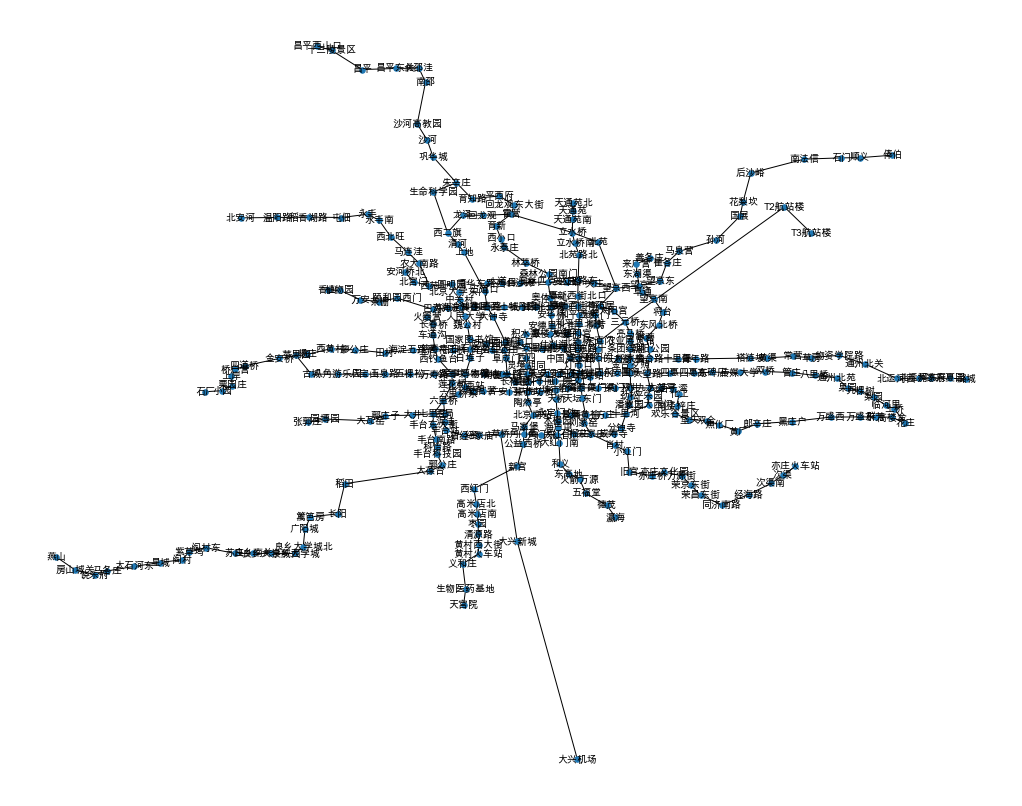

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 11))

station_graph = nx.Graph(station_connection_info)

station_graph.add_nodes_from(list(station_connection_info.keys()))
nx.draw(station_graph, station_info, with_labels=True, node_size=30, font_size = 10)

In [44]:
with open("beijing_subway.json", "w") as file:
        file.write(json.dumps(data, ensure_ascii=False) + "\n")

#### 3. Build the search agent

Build the search agent based ont he graph you built.

for example, if you use Beijing subway graoh, and you run:

\>>> search("奥体中心“，”天安门“）

You should get the result as follows: 奥体中心 -> A ->B ->C ... -> 天安门

In [52]:
def search_agent(start, destination, graph = station_connection_info):
    paths = [[start]] # list用来存储待搜索路径
    visited = set() # set用来存储已搜索的节点
    
    while paths:
        path = paths.pop(0) #提取第一条路径
        frontier = path[-1] #提取即将要探索的节点
        if frontier in visited: continue #检查如果该点已经搜索过，则不用再探索
        successors = graph[frontier]
        
        for city in successors: #遍历子节点
            if city in path: continue #check loop
            new_path = path + [city]
            paths.append(new_path) #bfs 将新路径加到list里
            #paths = [new_path] + paths #dfs
            if city == destination: #检查目的地是不是被搜索到了
                return new_path
        visited.add(frontier)
    
    

In [54]:
print(search_agent("郭公庄", "天安门西"))

['郭公庄', '丰台科技园', '科怡路', '丰台南路', '丰台东大街', '七里庄', '六里桥', '莲花桥', '公主坟', '军事博物馆', '木樨地', '南礼士路', '复兴门', '西单', '天安门西']


### (Optional) Improve your agent to make it able to find a path based on different strategies

###  <评阅点> : 是否正确得到不同目标下的路径。

Some ideas you might want to try:

a. Find the shortest path between two stations.

In [89]:
import math
# 地理距离
def geo_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

def get_station_distance(station1, station2):
    return geo_distance(station_info[station1], station_info[station2])

In [79]:
def search_by_strategy(start, destination, search_strategy, graph = station_connection_info):
    paths = [[start]]
    visited = set()
    while paths:
        path = paths.pop(0)
        frontier = path[-1]
        if frontier in visited: continue
        if frontier == destination:
            return path
        
        successors = graph[frontier]
        for city in successors:
            if city in path: continue
            new_path = path + [city]
            paths.append(new_path) # bfs
            # paths = [new_path] + paths # dfs
        
        paths = search_strategy(paths)
        visited.add(frontier)
    return paths
    

In [90]:
#路程排序
def sort_by_distance(pathes):
    def get_distance_of_path(path):
        distance = 0
        for i,_ in enumerate(path[:-1]):
            distance += get_station_distance(path[i],path[i+1])
        return distance
    return sorted(pathes,key=get_distance_of_path)

In [92]:
# 路程优先策略
def sort_by_distance(paths):
    def get_distance_of_path(paths_):
        distance = 0
        for i, _ in enumerate(paths_[:-1]):
            distance += get_station_distance(paths_[i], paths_[i+1])
        return distance
    return sorted(paths, key=get_distance_of_path)

In [103]:
search_by_strategy("长阳", "国贸", search_strategy=sort_by_distance)

['长阳',
 '稻田',
 '大葆台',
 '郭公庄',
 '丰台科技园',
 '科怡路',
 '丰台南路',
 '丰台东大街',
 '七里庄',
 '六里桥',
 '六里桥东',
 '北京西站',
 '湾子',
 '达官营',
 '广安门内',
 '菜市口',
 '宣武门',
 '和平门',
 '前门',
 '崇文门',
 '北京站',
 '建国门',
 '永安里',
 '国贸']

In [104]:
search_by_strategy("长阳", "国贸", search_strategy=lambda x:x)

['长阳',
 '稻田',
 '大葆台',
 '郭公庄',
 '丰台科技园',
 '科怡路',
 '丰台南路',
 '丰台东大街',
 '七里庄',
 '六里桥',
 '莲花桥',
 '公主坟',
 '军事博物馆',
 '木樨地',
 '南礼士路',
 '复兴门',
 '西单',
 '天安门西',
 '天安门东',
 '王府井',
 '东单',
 '建国门',
 '永安里',
 '国贸']

b. Find the path that requires minimum transfers between two stations.

In [111]:
# 换乘优先排序
import pdb
def sort_by_transfer(paths):
    def get_transfer_count(path):
        transfer = {}
#         pdb.set_trace()
        for i, _ in enumerate(path[:-1]):
            connection = path[i] + ',' + path[i+1]
            value = station_transfer_info[connection]
            transfer[value] = 1
        return len(transfer)
    return sorted(paths, key = get_transfer_count)

In [112]:
search_by_strategy("长阳", "国贸", search_strategy=sort_by_transfer)

['长阳',
 '稻田',
 '大葆台',
 '郭公庄',
 '丰台科技园',
 '科怡路',
 '丰台南路',
 '丰台东大街',
 '七里庄',
 '六里桥',
 '六里桥东',
 '北京西站',
 '军事博物馆',
 '木樨地',
 '南礼士路',
 '复兴门',
 '西单',
 '天安门西',
 '天安门东',
 '王府井',
 '东单',
 '建国门',
 '永安里',
 '国贸']

In [113]:
path_tran = ['长阳',
 '稻田',
 '大葆台',
 '郭公庄',
 '丰台科技园',
 '科怡路',
 '丰台南路',
 '丰台东大街',
 '七里庄',
 '六里桥',
 '六里桥东',
 '北京西站',
 '军事博物馆',
 '木樨地',
 '南礼士路',
 '复兴门',
 '西单',
 '天安门西',
 '天安门东',
 '王府井',
 '东单',
 '建国门',
 '永安里',
 '国贸']

In [121]:
path_dist = ['长阳',
 '稻田',
 '大葆台',
 '郭公庄',
 '丰台科技园',
 '科怡路',
 '丰台南路',
 '丰台东大街',
 '七里庄',
 '六里桥',
 '六里桥东',
 '北京西站',
 '湾子',
 '达官营',
 '广安门内',
 '菜市口',
 '宣武门',
 '和平门',
 '前门',
 '崇文门',
 '北京站',
 '建国门',
 '永安里',
 '国贸']

In [122]:
def get_transfer_count(path):
        transfer = {}
        for i, _ in enumerate(path[:-1]):
            connection = path[i] + ',' + path[i+1]
            value = station_transfer_info[connection]
            transfer[value] = 1
        return len(transfer)

In [123]:
get_transfer_count(path_dist)

6

c. Combine the previous two ideas, find a more suitable path.

Compare your results with results obtained by using some apps such as Baidu map, A map, Google map or Apple map. If there is difference, try to explanate it.

## Congratulations ! You have finished the assignment of week 2.

![title](img/agent.png)

### If you have any suggestions regarding the teaching, please feel free to send them to my eamil (eric.lee.xiao@gmail.com) 